<a href="https://colab.research.google.com/github/StanleyLiangYork/PytorchCode/blob/main/Fashion_MNIST_Classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A concise code version for Fashion MNIST classification

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dsets
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import numpy as np

In [2]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
IMAGE_SIZE = 32
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [5]:
train_dataset = dsets.FashionMNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [7]:
def show_data(data_sample, IMAGE_SIZE=32):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(output_label(data_sample[1])))

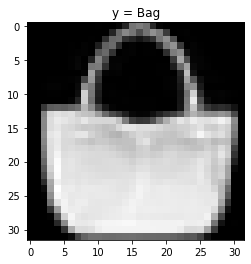

In [8]:
show_data(train_dataset[100])

Build a Convolutional Neural Network Class

In [9]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self):
        super(CNN, self).__init__()
        self.module1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            ) # 16*16*32
        
        self.module2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            ) # 8*8*64
        
        self.module3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            ) # 4*4*128

        self.flat = nn.Flatten()    
        self.fc1 = nn.Linear(in_features=4*4*128, out_features=4*4*128)
        self.drop = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(in_features=4*4*128, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=10)
    
    # Prediction
    def forward(self, x):
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [10]:
model = CNN()

In [11]:
print(model)

CNN(
  (module1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (module2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (module3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (f

In [12]:
print(f'data in training set: {len(train_dataset)}')
print(f'data in validation set: {len(validation_dataset)}')

data in training set: 60000
data in validation set: 10000


In [13]:
criterion = nn.CrossEntropyLoss(reduction="sum")
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=200)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1000)

In [14]:
from sklearn.utils import validation

best_model = None
n_epochs = 40
model.to(device)
best_model = None
best_loss = np.inf
N_test = len(validation_dataset)
loss_list = []
epoch_loss = []
epoch_acc = []
epoch_val_loss = []

In [15]:
for epoch in range(n_epochs):
  model.train()
  for X_batch, y_batch in train_loader:
    y_pred = model(X_batch.to(device))
    loss = criterion(y_pred, y_batch.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
  epoch_loss.append(np.sum(loss_list))
  loss_list = []
  
  # validation
  correct = 0
  val_loss = 0
  model.eval()
  with torch.no_grad():
    for X_batch, y_batch in validation_loader:
      y_pred = model(X_batch.to(device))
      val_loss += criterion(y_pred, y_batch.to(device))
      _, yhat = torch.max(y_pred.data,1)
      correct += (yhat == y_batch.to(device)).sum().item()
    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model.state_dict()


    epoch_val_loss.append(val_loss.item())
    accuracy = correct / N_test
    epoch_acc.append(accuracy)
  
  print("Epoch {0:3d} -- loss: {1:.4f} -- val loss: {2:.4f} -- val acc: {3:.4f}".format(epoch, epoch_loss[epoch], epoch_val_loss[epoch], epoch_acc[epoch]))

torch.save(best_model, "FMNIST.pth")

Epoch   0 -- loss: 56599.3360 -- val loss: 5858.5981 -- val acc: 0.7827
Epoch   1 -- loss: 22505.3756 -- val loss: 4905.4126 -- val acc: 0.8268
Epoch   2 -- loss: 19211.1015 -- val loss: 4677.4521 -- val acc: 0.8255
Epoch   3 -- loss: 17983.2999 -- val loss: 3784.1023 -- val acc: 0.8624
Epoch   4 -- loss: 17096.1872 -- val loss: 3439.3557 -- val acc: 0.8783
Epoch   5 -- loss: 16600.1250 -- val loss: 4011.6697 -- val acc: 0.8572
Epoch   6 -- loss: 15846.2318 -- val loss: 3322.5605 -- val acc: 0.8831
Epoch   7 -- loss: 14984.2980 -- val loss: 3914.8960 -- val acc: 0.8544
Epoch   8 -- loss: 14340.5310 -- val loss: 3616.5735 -- val acc: 0.8710
Epoch   9 -- loss: 13674.0782 -- val loss: 3262.1958 -- val acc: 0.8889
Epoch  10 -- loss: 13094.0955 -- val loss: 3623.0256 -- val acc: 0.8714
Epoch  11 -- loss: 12354.4668 -- val loss: 3878.7610 -- val acc: 0.8725
Epoch  12 -- loss: 12000.0604 -- val loss: 3736.6370 -- val acc: 0.8690
Epoch  13 -- loss: 11636.7260 -- val loss: 3740.4871 -- val acc:

Text(0.5, 0, 'epoch')

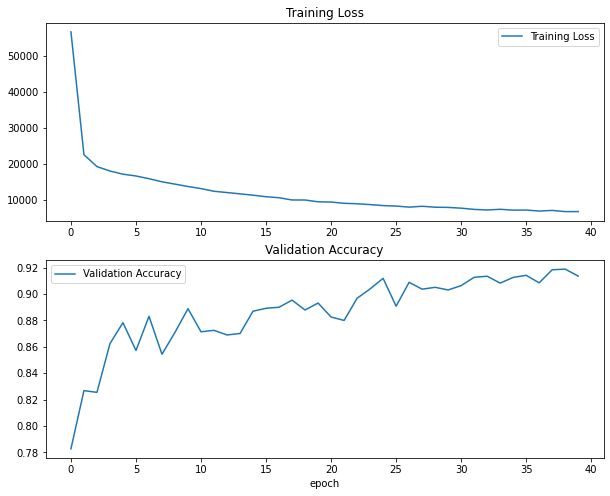

In [16]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(epoch_loss, label='Training Loss')
plt.legend(loc='best')
plt.title('Training Loss')

plt.subplot(2, 1, 2)
plt.plot(epoch_acc, label='Validation Accuracy')
plt.plot()
plt.legend(loc='best')
plt.title('Validation Accuracy')
plt.xlabel('epoch')

load the best model: 1-load the dicts from file, 2-load the parameters to the object 

In [17]:
best_model = torch.load("FMNIST.pth")
model.load_state_dict(best_model)

<All keys matched successfully>

In [18]:
correct = 0
N_test = 10000

for x_test, y_test in validation_loader:
  x_test, y_test = x_test.to(device), y_test.to(device)
  z = model(x_test)
  _, yhat = torch.max(z.data,1)
  correct += (yhat == y_test).sum().item()
  accuracy = correct / N_test

print(f'Trained Model accuracy: {accuracy}')

Trained Model accuracy: 0.9136
